In [1]:
%run ../common_functions.py

read_dataset()
read_all_datasets()
read_processed_data()
combine_text_columns()
split_train_test()
extract_data()
evaluate_model()
detect_missing_values()


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sentence_transformers import SentenceTransformer
import torch

## Load in Dataset

In [3]:
train_data, test_data = read_processed_data(augmented=False, balanced=False)

## Train Random Forest

### Extract data and label mapping

In [4]:
X_train, y_train, X_test, y_test = extract_data(train_df=train_data, test_df=test_data, text_col='text', label_col='label')

### Convert text to vectors

In [5]:
device = torch.device("cuda" if torch.cuda.is_available()
                      else "mps" if torch.backends.mps.is_available()
                      else "cpu")
print(f"Using device >> {device}")

embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device=device)

X_train_emb = embedder.encode(
    X_train, batch_size=48, show_progress_bar=True
)

X_test_emb = embedder.encode(
    X_test, batch_size=48
)

Using device >> mps


Batches:   0%|          | 0/6085 [00:00<?, ?it/s]

In [6]:
model = RandomForestClassifier(
    n_estimators=400,
    criterion='entropy',
    max_features='sqrt',
    class_weight='balanced',
    bootstrap=True
)
model.fit(X_train_emb, y_train)

KeyboardInterrupt: 

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.70      0.66       958
           1       0.69      0.63      0.66      1042

    accuracy                           0.66      2000
   macro avg       0.66      0.66      0.66      2000
weighted avg       0.67      0.66      0.66      2000


Overall Metrics:
Accuracy       : 0.6625
Precision (avg): 0.6652
Recall    (avg): 0.6625
F1 Score  (avg): 0.6624



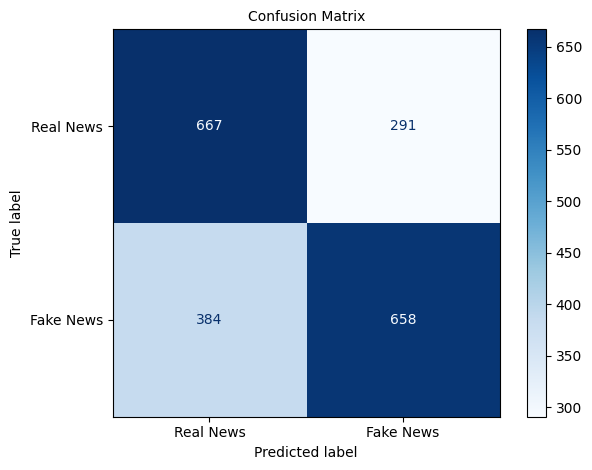

In [8]:
y_pred = model.predict(X_test_emb)
evaluate_model(y_test=y_test, y_pred=y_pred)

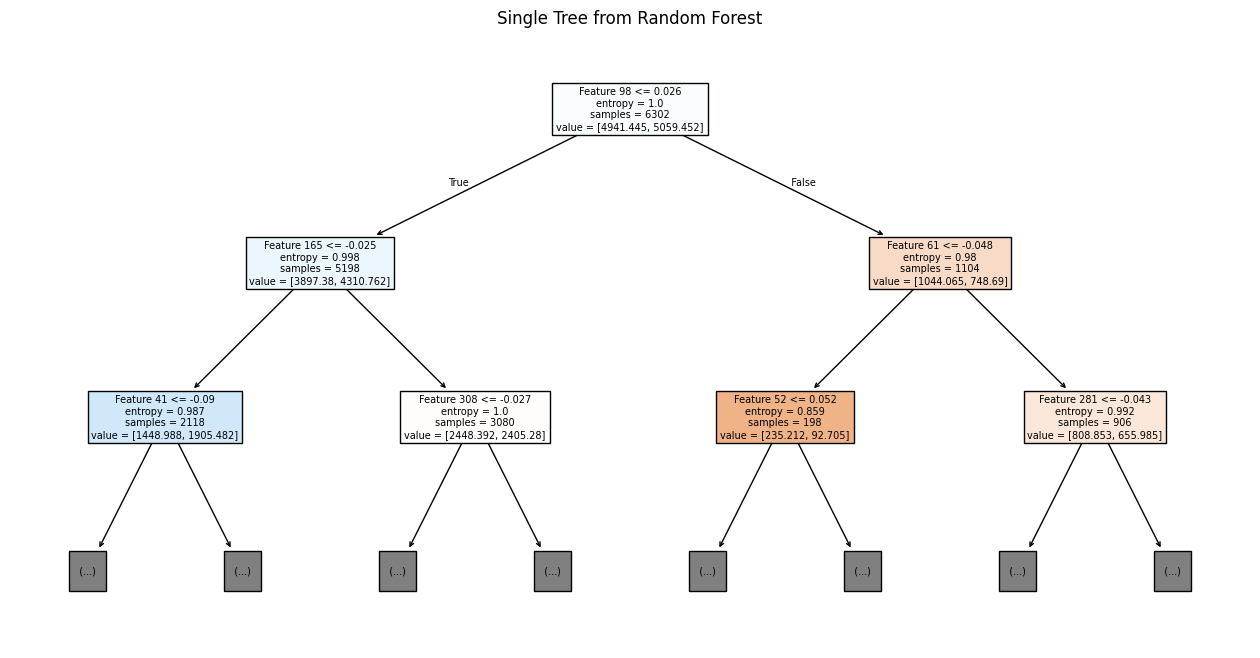

In [17]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Pick one tree from the forest
estimator = model.estimators_[0]
feature_names = [f"Feature {i}" for i in range(X_train_emb.shape[1])]

# Plot the tree
plt.figure(figsize=(16, 8))
plot_tree(estimator, filled=True, feature_names=feature_names, max_depth=2)
plt.title("Single Tree from Random Forest")
plt.show()